In [1]:
%tensorflow_version 1.x
import tensorflow as tf
#tf.enable_eager_execution()
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy import optimize
import matplotlib.dates as dates
from ipywidgets import interact, widgets
from scipy.integrate import solve_ivp
plt.style.use('seaborn-poster')
matplotlib.rcParams['figure.figsize'] = (10., 6.)
import copy
import sympy
%matplotlib inline
import scipy as sp
from scipy.integrate import odeint
import datetime as dt
import timeit
import time
import os
from scipy.interpolate import CubicSpline
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
np.set_printoptions(threshold=np.inf)
from prettytable import PrettyTable  
import matplotlib as mpl

TensorFlow 1.x selected.


In [8]:
data = pd.read_csv("https://raw.githubusercontent.com/Jiel73654/Qualify-Exam_JieLong/master/Rutherford.csv",error_bad_lines = False)

In [71]:
data[29:]

,DATE,COUNTY,TOTAL_CASES,NEW_CASES,NEW_RECOVERED,TOTAL_RECOVERED,NEW_DEATHS,TOTAL_DEATHS
29,4/10/2020,Rutherford,222.0,19.0,NaN,49.0,0.0,6.0
30,4/11/2020,Rutherford,235.0,13.0,11.0,60.0,0.0,6.0
31,4/12/2020,Rutherford,243.0,8.0,8.0,68.0,0.0,6.0
32,4/13/2020,Rutherford,250.0,7.0,16.0,84.0,0.0,6.0
33,4/14/2020,Rutherford,253.0,3.0,9.0,93.0,0.0,6.0
...,...,...,...,...,...,...,...,...
140,7/31/2020,Rutherford,5899.0,146.0,108.0,3116.0,2.0,51.0
141,8/1/2020,Rutherford,5999.0,100.0,65.0,3181.0,0.0,51.0
142,8/2/2020,Rutherford,6042.0,43.0,29.0,3210.0,0.0,51.0
143,8/3/2020,Rutherford,6072.0,30.0,96.0,3306.0,2.0,53.0


In [47]:
length = 116#time period
ic = data["TOTAL_CASES"]
IC = ic.iloc[29:].to_numpy().reshape(116,1)
dc = data["TOTAL_DEATHS"]
DC = dc.iloc[29:].to_numpy().reshape(116,1)
re = data["TOTAL_RECOVERED"]
RC = re.iloc[29:].to_numpy().reshape(116,1)

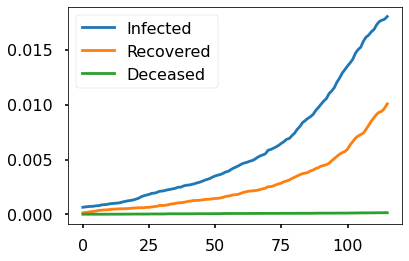

In [17]:
N0 = 341316#The total population of tennessee
T = np.arange(0,length).reshape(length,1)
II = IC - RC - DC
SS = N0 - II - RC - DC
RR = RC + DC
plt.plot(T,IC/N0)
plt.plot(T,RC/N0);
plt.plot(T,DC/N0)
plt.legend(("Infected","Recovered","Deceased"))

In [88]:
np.random.seed(12345)
tf.set_random_seed(12345)
#tf.compat.v1.disable_eager_execution()
class SIR:
    def __init__(self, I, R, S, T,N0, layers):
        self.t = T
        self.I = I
        self.R = R
        self.S = S
        self.layers = layers
        self.N = N0
        self.lb = T.min()
        self.ub = T.max()
        # Initialize NN
        self.weights1, self.biases1 = self.initialize_NN(self.layers)
        self.weights2, self.biases2 = self.initialize_NN(self.layers)
        self.weights3, self.biases3 = self.initialize_NN(self.layers)
        self.weights4, self.biases4 = self.initialize_NN(self.layers)
        self.weights5, self.biases5 = self.initialize_NN(self.layers)
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        self.I_tf = tf.placeholder(tf.float32, shape=[None, self.I.shape[1]])
        self.R_tf = tf.placeholder(tf.float32, shape=[None, self.R.shape[1]])
        self.S_tf = tf.placeholder(tf.float32, shape=[None, self.S.shape[1]])
        self.S_pred, self.I_pred, self.R_pred,self.beta_pred,self.gamma_pred,self.E1_pred, self.E2_pred, self.E3_pred, self.E4_pred = self.net_NS(
            self.t_tf)
        self.GE_loss = tf.reduce_mean(tf.abs(self.E1_pred)) + tf.reduce_mean(tf.abs(self.E2_pred)) +\
                        tf.reduce_mean(tf.abs(self.E3_pred)) + tf.reduce_mean(tf.abs(self.E4_pred))
        self.S_loss = 0
        self.I_loss = 0
        self.R_loss = 0
        iter = 0
        for i in range(len(T)):
            if T[i]%1 == 0:
                self.S_loss += tf.abs(self.S_tf[iter] - self.S_pred[i])
                self.I_loss += tf.abs(self.I_tf[iter] - self.I_pred[i])
                self.R_loss += tf.abs(self.R_tf[iter] - self.R_pred[i])
                iter += 1
        self.OB_loss = (self.I_loss + self.R_loss + self.S_loss)/iter
        self.loss = self.OB_loss + self.GE_loss
        '''
        self.loss = tf.reduce_mean(tf.abs(self.I_tf - self.I_pred)) + tf.reduce_mean(tf.abs(self.R_pred - self.R_tf)) +\
                    tf.reduce_mean(tf.abs(self.S_tf - self.S_pred)) +\
                    tf.reduce_mean(tf.abs(self.E1_pred))+ tf.reduce_mean(tf.abs(self.E2_pred)) +\
                    tf.reduce_mean(tf.abs(self.E3_pred)) + tf.reduce_mean(tf.abs(self.E4_pred)) 
        '''
        
        self.optimizer_Adam = tf.compat.v1.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        # Optimizers
        '''
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})    
        '''                                                                                          
        init = tf.global_variables_initializer()
        self.sess.run(init)
         
        
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers)
        
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
    
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.nn.softplus(tf.add(tf.matmul(H, W), b))
        return Y

    def neural_net1(self, X, weights, biases):
        num_layers = len(weights) + 1
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.nn.sigmoid(tf.add(tf.matmul(H, W), b))
        return Y

    def net_NS(self, t):
        #gamma = self.gamma
        #beta = self.beta
        #print(x.shape)
        #print(y.shape)
        #output = self.neural_net(t, self.weights1, self.biases1)
        beta = self.neural_net1(t,self.weights4,self.biases4)
        gamma = self.neural_net1(t,self.weights5,self.biases5)
        NN=self.N
        S = self.neural_net1(t, self.weights1, self.biases1)
        I = self.neural_net1(t, self.weights2, self.biases2)
        R = self.neural_net1(t, self.weights3, self.biases3)
        #beta = output[:,3:4]
        #gamma = output[:,4:5]
        st = tf.gradients(S, t)[0]
        It = tf.gradients(I, t)[0]  
        Rt = tf.gradients(R, t)[0]
        
        E1 = st + beta*S*I
        E2 = It - beta*S*I + gamma*I
        E3 = Rt - gamma*I
        E4 = 1 - (S+I+R)
        return S,I,R,beta,gamma,E1,E2,E3,E4

    def callback(self, loss):
        print('Loss: %.3e' % (loss))
    def train(self, nIter): 

        tf_dict = {self.t_tf: self.t, self.I_tf: self.I,self.R_tf: self.R,self.S_tf: self.S}
                   
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 500 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                #gamma_value = self.sess.run(self.gamma)
                #beta_value = self.sess.run(self.beta)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value,elapsed))
                start_time = time.time()
        '''
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss],
                                loss_callback = self.callback)
        '''              
    def predict(self, t_star):
        tf_dict = {self.t_tf: t_star}
        S = self.sess.run(self.S_pred, tf_dict)
        I = self.sess.run(self.I_pred, tf_dict)
        R = self.sess.run(self.R_pred, tf_dict)
        beta = self.sess.run(self.beta_pred,tf_dict)
        gamma = self.sess.run(self.gamma_pred,tf_dict)
        #gamma = self.sess.run(self.gamma_pred,tf_dict)
        return S,I,R,beta,gamma

In [89]:
T = np.arange(0,length - 0.1,0.1)#here I used Nt with 0.1 stepsize
T = T.reshape(len(T),1)
layers = [1,64,64,64,1]
model = SIR(II/N0,RR/N0,SS/N0,T,1,layers)
model.train(100000)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

It: 0, Loss: 2.453e+00, Time: 6.06
It: 500, Loss: 8.614e-04, Time: 14.55
It: 1000, Loss: 8.965e-04, Time: 14.46
It: 1500, Loss: 7.015e-04, Time: 16.28
It: 2000, Loss: 7.043e-04, Time: 13.69
It: 2500, Loss: 8.769e-04, Time: 13.74
It: 3000, Loss: 6.720e-04, Time: 13.87
It: 3500, Loss: 8.900e-04, Time: 13.75
It: 4000, Loss: 9.223e-04, Time: 13.68
It: 4500, Loss: 9.974e-04, Time: 13.87
It: 5000, Loss: 7.453e-04, Time: 13.76
It: 5500, Loss: 7.894e-04, Time: 13.62
It: 6000, Loss: 6.945e-04, Time: 13.65
It: 6500, Loss: 9.633e-04, Time: 13.66
It: 7000, Loss: 7.504e-04, Time: 13.73
It: 7500, Loss: 8.177e-04, Time: 13.78
It: 8000, Loss: 7.038e-04, Time: 13.96
It: 8500, Loss: 6.654e-04, Time: 13.64
It: 9000, Loss: 7.044e-04, Time: 13.82
It: 9500, Loss: 5.941e-04, Time: 13.64
It: 10000, Loss: 7.941e-04, Time: 13.63
It: 10500, Loss: 6.261e-04, Time: 13.67
It: 11000, Loss: 6.216e-04, Time: 13.70
It: 11500, Lo

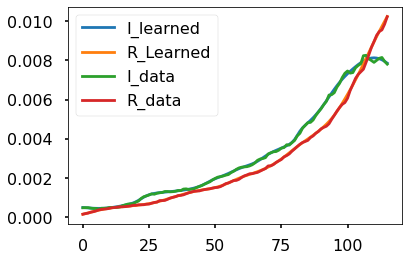

In [90]:
T = np.arange(0,116).reshape(116,1)
s,i,r,beta,gamma= model.predict(T)
plt.plot(T,i)
plt.plot(T,r)
I1 = II/N0
R1 = RR/N0
plt.plot(T,I1)
plt.plot(T,R1)
plt.legend(("I_learned","R_Learned","I_data","R_data"))

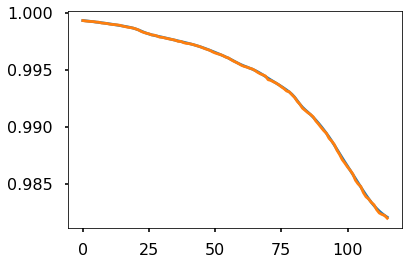

In [91]:
plt.plot(T,s)
plt.plot(T,SS/N0)

[9.99349576e-01 4.89282659e-04 1.61140995e-04]
[0.98608146]


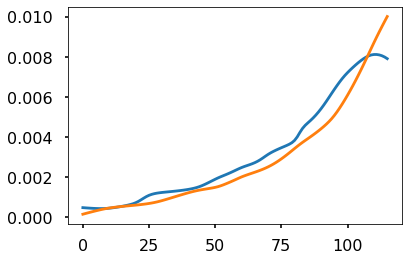

In [92]:
from scipy.integrate import odeint
# function that returns dz/dt
def sir_model(z,t,beta_value,gamma):
    s = z[0,]
    i = z[1,]
    r = z[2,]
    dsdt = -beta_value*i*s
    didt = beta_value*i*s - gamma*i
    drdt = gamma*i
    dzdt = [dsdt,didt,drdt]
    dzdt = np.array(dzdt)
    return dzdt
t = np.arange(0,T.shape[0])
# initial condition
z0 = np.array([SS[0,0]/N0,II[0,0]/N0,RR[0,0]/N0])
print(z0)
rk_s = [0.0]*T.shape[0]
rk_i = [0.0]*T.shape[0]
rk_r = [0.0]*T.shape[0]
rk_s[0] = z0[0]
rk_i[0] = z0[1]
rk_r[0] = z0[2]
# solve ODE
for l in range(1,T.shape[0]):
  # span for next time step
    tspan = [t[l-1],t[l]]
    # solve for next step
    z = odeint(sir_model,z0,tspan,args=(beta[l-1,0],gamma[l-1,0]))
    # store solution for plotting
    rk_s[l] = z[1][0]
    rk_i[l] = z[1][1]
    rk_r[l] = z[1][2]
    # next initial condition
    z0 = z[1]
plt.plot(t,rk_i)
plt.plot(t,rk_r)
#plt.plot(t,rk_s)
mul = I1[-1]/rk_i[-1]
print(mul)

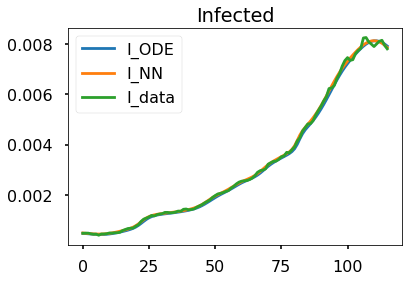

Text(0.5, 1.0, 'Relative Error')

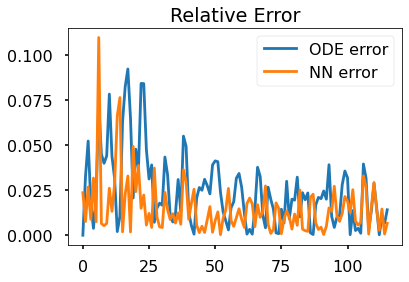

In [93]:
#here the graph is the difference between the data and RK solved
plt.plot(t,rk_i)
plt.plot(T,i)
plt.plot(T,II/N0)
plt.legend(("I_ODE","I_NN","I_data"))
plt.title("Infected")
plt.show()
#compute the error
plt.plot(np.abs(np.array(rk_i).reshape(length,1) - II/N0)/(II/N0))
plt.plot(np.abs(i - II/N0)/(II/N0))
plt.legend(("ODE error","NN error"))
plt.title("Relative Error")

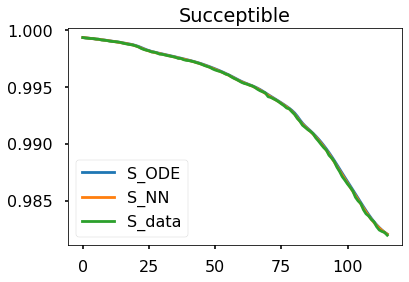

Text(0.5, 1.0, 'Relative Error')

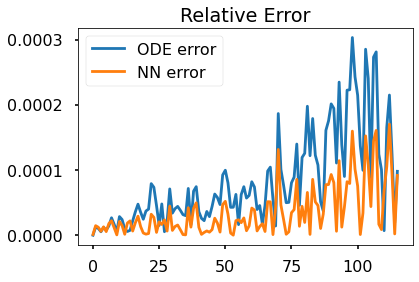

In [94]:
plt.plot(t,rk_s)
plt.plot(T,s)
plt.plot(T,SS/N0)
plt.legend(("S_ODE","S_NN","S_data"))
plt.title("Succeptible")
plt.show()
#compute the error
plt.plot(np.abs(np.array(rk_s).reshape(length,1) - SS/N0)/(SS/N0))
plt.plot(np.abs(s - SS/N0)/(SS/N0))
plt.legend(("ODE error","NN error"))
plt.title("Relative Error")

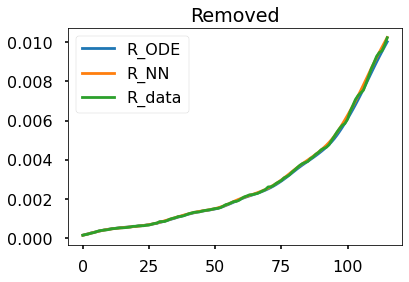

Text(0.5, 1.0, 'Relative Error')

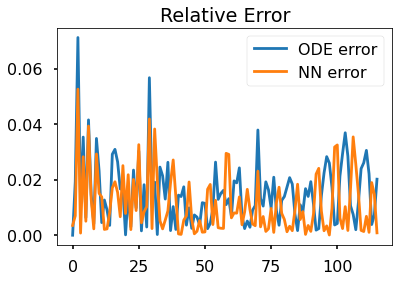

In [95]:
plt.plot(t,rk_r)
plt.plot(T,r)
plt.plot(T,RR/N0)
plt.legend(("R_ODE","R_NN","R_data"))
plt.title("Removed")
plt.show()
#compute the error
plt.plot(np.abs(np.array(rk_r).reshape(length,1) - RR/N0)/(RR/N0))
plt.plot(np.abs(r - RR/N0)/(RR/N0))
plt.legend(("ODE error","NN error"))
plt.title("Relative Error")

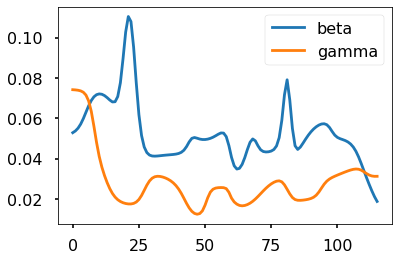

In [96]:
plt.plot(T,beta)
plt.plot(T,gamma)
plt.legend(("beta","gamma"))

Text(0.5, 1.0, 'Reproduciton Number')

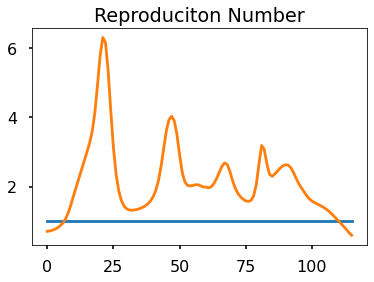

In [97]:
aa = [1]*116
plt.plot(T,aa)
plt.plot(T,beta/gamma)
plt.title("Reproduciton Number")

In [98]:
#SIRD model
np.random.seed(12345)
tf.set_random_seed(12345)
#tf.compat.v1.disable_eager_execution()
class SIRD:
    def __init__(self, I, R, S,D, T,N0, layers):
        self.t = T
        self.I = I
        self.R = R
        self.S = S
        self.D = D
        self.layers = layers
        self.N = N0
        self.lb = T.min()
        self.ub = T.max()
        # Initialize NN
        self.weights1, self.biases1 = self.initialize_NN(self.layers)
        self.weights2, self.biases2 = self.initialize_NN(self.layers)
        self.weights3, self.biases3 = self.initialize_NN(self.layers)
        self.weights4, self.biases4 = self.initialize_NN(self.layers)
        self.weights5, self.biases5 = self.initialize_NN(self.layers)
        self.weights6, self.biases6 = self.initialize_NN(self.layers)
        self.weights7, self.biases7 = self.initialize_NN(self.layers)
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        self.I_tf = tf.placeholder(tf.float32, shape=[None, self.I.shape[1]])
        self.R_tf = tf.placeholder(tf.float32, shape=[None, self.R.shape[1]])
        self.S_tf = tf.placeholder(tf.float32, shape=[None, self.S.shape[1]])
        self.D_tf = tf.placeholder(tf.float32, shape=[None, self.D.shape[1]])
        self.S_pred, self.I_pred, self.R_pred,self.D_pred,self.beta_pred,self.gamma_pred,self.mu_pred,self.E1_pred, self.E2_pred, self.E3_pred, self.E4_pred,self.E5_pred = self.net_NS(
            self.t_tf)
        self.GE_loss = tf.reduce_mean(tf.abs(self.E1_pred)) + tf.reduce_mean(tf.abs(self.E2_pred)) +\
                        tf.reduce_mean(tf.abs(self.E3_pred)) + tf.reduce_mean(tf.abs(self.E4_pred)) + tf.reduce_mean(tf.abs(self.E5_pred))
        self.S_loss = 0
        self.I_loss = 0
        self.R_loss = 0
        self.D_loss = 0
        iter = 0
        for i in range(len(T)):
            if T[i]%1 == 0:
                self.S_loss += tf.abs(self.S_tf[iter] - self.S_pred[i])
                self.I_loss += tf.abs(self.I_tf[iter] - self.I_pred[i])
                self.R_loss += tf.abs(self.R_tf[iter] - self.R_pred[i])
                self.D_loss += tf.abs(self.D_tf[iter] - self.D_pred[i])
                iter += 1
        self.OB_loss = (self.I_loss + self.R_loss + self.S_loss + self.D_loss)/iter
        self.loss = self.OB_loss + self.GE_loss
        '''
        self.loss = tf.reduce_mean(tf.abs(self.I_tf - self.I_pred)) + tf.reduce_mean(tf.abs(self.R_pred - self.R_tf)) +\
                    tf.reduce_mean(tf.abs(self.S_tf - self.S_pred)) +\
                    tf.reduce_mean(tf.abs(self.E1_pred))+ tf.reduce_mean(tf.abs(self.E2_pred)) +\
                    tf.reduce_mean(tf.abs(self.E3_pred)) + tf.reduce_mean(tf.abs(self.E4_pred)) 
        '''
        
        self.optimizer_Adam = tf.compat.v1.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        # Optimizers
        '''
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})    
        '''                                                                                          
        init = tf.global_variables_initializer()
        self.sess.run(init)
         
        
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers)
        
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
    
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.nn.softplus(tf.add(tf.matmul(H, W), b))
        return Y

    def neural_net1(self, X, weights, biases):
        num_layers = len(weights) + 1
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.nn.sigmoid(tf.add(tf.matmul(H, W), b))
        return Y

    def net_NS(self, t):
        #gamma = self.gamma
        #beta = self.beta
        #print(x.shape)
        #print(y.shape)
        #output = self.neural_net(t, self.weights1, self.biases1)
        beta = self.neural_net1(t,self.weights4,self.biases4)
        gamma = self.neural_net1(t,self.weights5,self.biases5)
        mu = self.neural_net1(t,self.weights6,self.biases6)
        NN=self.N
        S = self.neural_net1(t, self.weights1, self.biases1)
        I = self.neural_net1(t, self.weights2, self.biases2)
        R = self.neural_net1(t, self.weights3, self.biases3)
        D = self.neural_net1(t, self.weights7, self.biases7)
        #beta = output[:,3:4]
        #gamma = output[:,4:5]
        St = tf.gradients(S, t)[0]
        It = tf.gradients(I, t)[0]  
        Rt = tf.gradients(R, t)[0]
        Dt = tf.gradients(D, t)[0]
        E1 = St + beta*S*I
        E2 = It - beta*S*I + (mu+gamma)*I
        E3 = Rt - gamma*I
        E4 = Dt - mu*I
        E5 = 1 - (S+I+R+D)
        return S,I,R,D,beta,gamma,mu,E1,E2,E3,E4,E5

    def callback(self, loss):
        print('Loss: %.3e' % (loss))
    def train(self, nIter): 

        tf_dict = {self.t_tf: self.t, self.I_tf: self.I,self.R_tf: self.R,self.S_tf: self.S,self.D_tf: self.D}
                   
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 500 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                #gamma_value = self.sess.run(self.gamma)
                #beta_value = self.sess.run(self.beta)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value,elapsed))
                start_time = time.time()
        '''
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss],
                                loss_callback = self.callback)
        '''              
    def predict(self, t_star):
        tf_dict = {self.t_tf: t_star}
        S = self.sess.run(self.S_pred, tf_dict)
        I = self.sess.run(self.I_pred, tf_dict)
        R = self.sess.run(self.R_pred, tf_dict)
        D = self.sess.run(self.D_pred, tf_dict)
        beta = self.sess.run(self.beta_pred,tf_dict)
        gamma = self.sess.run(self.gamma_pred,tf_dict)
        mu = self.sess.run(self.mu_pred,tf_dict)
        #gamma = self.sess.run(self.gamma_pred,tf_dict)
        return S,I,R,D,beta,gamma,mu

In [99]:
model1 = SIRD(II/N0,RC/N0,SS/N0,DC/N0,T,1,layers)
model1.train(100000)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

It: 0, Loss: 3.929e+00, Time: 7.80
It: 500, Loss: 8.411e-04, Time: 5.89
It: 1000, Loss: 9.451e-04, Time: 5.97
It: 1500, Loss: 7.211e-04, Time: 6.04
It: 2000, Loss: 1.181e-03, Time: 5.96
It: 2500, Loss: 1.038e-03, Time: 6.08
It: 3000, Loss: 8.498e-04, Time: 5.99
It: 3500, Loss: 8.163e-04, Time: 6.00
It: 4000, Loss: 1.046e-03, Time: 6.01
It: 4500, Loss: 8.194e-04, Time: 6.01
It: 5000, Loss: 8.751e-04, Time: 6.11
It: 5500, Loss: 9.239e-04, Time: 6.10
It: 6000, Loss: 6.337e-04, Time: 6.02
It: 6500, Loss: 6.714e-04, Time: 6.17
It: 7000, Loss: 1.601e-03, Time: 6.00
It: 7500, Loss: 8.186e-04, Time: 6.06
It: 8000, Loss: 9.493e-04, Time: 5.98
It: 8500, Loss: 7.588e-04, Time: 6.49
It: 9000, Loss: 6.643e-04, Time: 6.32
It: 9500, Loss: 6.794e-04, Time: 6.53
It: 10000, Loss: 7.396e-04, Time: 6.44
It: 10500, Loss: 6.934e-04, Time: 5.92
It: 11000, Loss: 7.469e-04, Time: 6.08
It: 11500, Loss: 7.081e-04, Time: 6

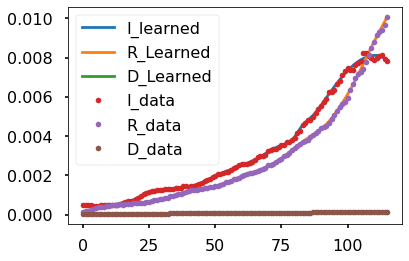

In [100]:
T = np.arange(0,116).reshape(116,1)
s1,i1,r1,d1,beta1,gamma1,mu1= model1.predict(T)
plt.plot(T,i1)
plt.plot(T,r1)
plt.plot(t,d1)
plt.plot(T,II/N0,'.')
plt.plot(T,RC/N0,'.')
plt.plot(T,DC/N0,'.')
plt.legend(("I_learned","R_Learned","D_Learned","I_data","R_data","D_data"))

[9.99349576e-01 4.89282659e-04 1.43561978e-04 1.75790177e-05]
[0.98608146]


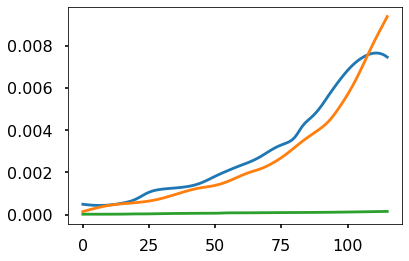

In [101]:
def sird_model(z,t,beta_value,gamma,mu):
    s = z[0,]
    i = z[1,]
    r = z[2,]
    dsdt = -beta_value*i*s
    didt = beta_value*i*s - (mu+gamma)*i
    drdt = gamma*i
    dddt = mu*i
    dzdt = [dsdt,didt,drdt,dddt]
    dzdt = np.array(dzdt)
    return dzdt
t1 = np.arange(0,T.shape[0])
# initial condition
z10 = np.array([SS[0,0]/N0,II[0,0]/N0,RC[0,0]/N0,DC[0,0]/N0])
print(z10)
rk1_s = [0.0]*T.shape[0]
rk1_i = [0.0]*T.shape[0]
rk1_r = [0.0]*T.shape[0]
rk1_d = [0.0]*T.shape[0]
rk1_s[0] = z10[0]
rk1_i[0] = z10[1]
rk1_r[0] = z10[2]
rk1_d[0] = z10[3]
# solve ODE
for l in range(1,T.shape[0]):
  # span for next time step
    tspan = [t[l-1],t[l]]
    # solve for next step
    z1 = odeint(sird_model,z10,tspan,args=(beta1[l-1,0],gamma1[l-1,0],mu1[l-1,0]))
    # store solution for plotting
    rk1_s[l] = z1[1][0]
    rk1_i[l] = z1[1][1]
    rk1_r[l] = z1[1][2]
    rk1_d[l] = z1[1][3]
    # next initial condition
    z10 = z1[1]
plt.plot(t,rk1_i)
plt.plot(t,rk1_r)
plt.plot(t,rk1_d)
mul = I1[-1]/rk_i[-1]
print(mul)

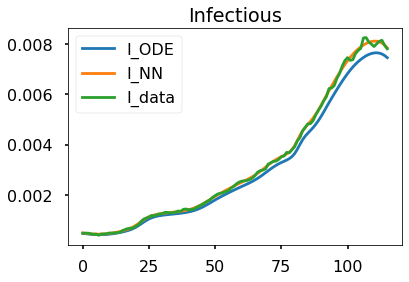

Text(0.5, 1.0, 'Relative Error')

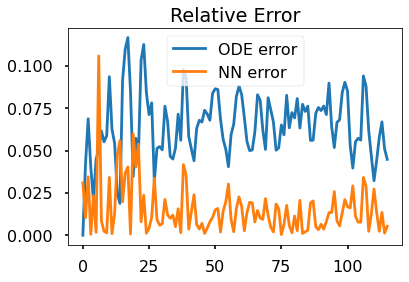

In [102]:
#here the graph is the difference between the data and RK solved
plt.plot(t,rk1_i)
plt.plot(t,i1)
plt.plot(T,II/N0)
plt.legend(("I_ODE","I_NN","I_data"))
plt.title("Infectious")
plt.show()
#compute the error
plt.plot(np.abs(np.array(rk1_i).reshape(length,1) - II/N0)/(II/N0))
plt.plot(np.abs(i1 - II/N0)/(II/N0))
plt.legend(("ODE error","NN error"))
plt.title("Relative Error")

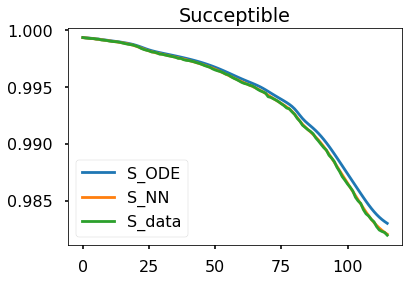

Text(0.5, 1.0, 'Relative Error')

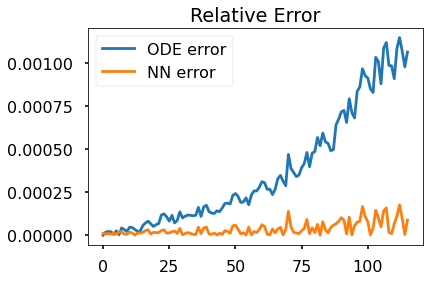

In [103]:
plt.plot(t,rk1_s)
plt.plot(T,s1)
plt.plot(T,SS/N0)
plt.legend(("S_ODE","S_NN","S_data"))
plt.title("Succeptible")
plt.show()
#compute the error
plt.plot(np.abs(np.array(rk1_s).reshape(length,1) - SS/N0)/(SS/N0))
plt.plot(np.abs(s1 - SS/N0)/(SS/N0))
plt.legend(("ODE error","NN error"))
plt.title("Relative Error")

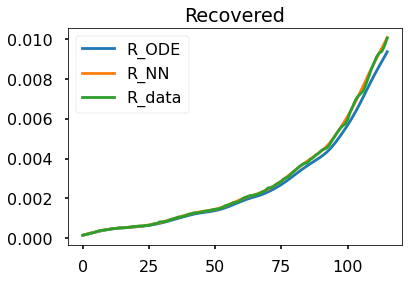

Text(0.5, 1.0, 'Relative Error')

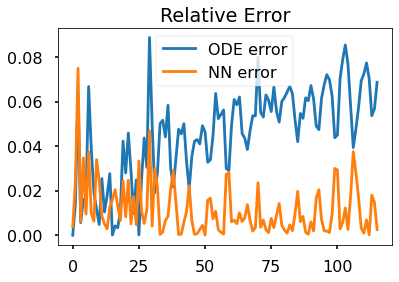

In [104]:
plt.plot(t,rk1_r)
plt.plot(T,r1)
plt.plot(T,RC/N0)
plt.legend(("R_ODE","R_NN","R_data"))
plt.title("Recovered")
plt.show()
#compute the error
plt.plot(np.abs(np.array(rk1_r).reshape(length,1) - RC/N0)/(RC/N0))
plt.plot(np.abs(r1 - RC/N0)/(RC/N0))
plt.legend(("ODE error","NN error"))
plt.title("Relative Error")

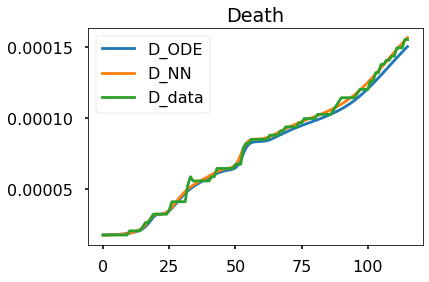

Text(0.5, 1.0, 'Relative Error')

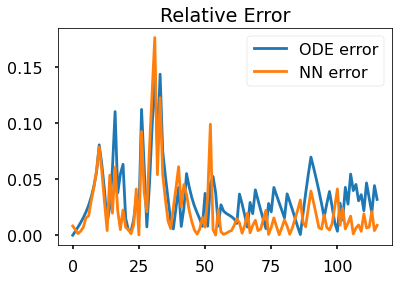

In [105]:
plt.plot(t,rk1_d)
plt.plot(T,d1)
plt.plot(T,DC/N0)
plt.legend(("D_ODE","D_NN","D_data"))
plt.title("Death")
plt.show()
#compute the error
plt.plot(np.abs(np.array(rk1_d).reshape(length,1) - DC/N0)/(DC/N0))
plt.plot(np.abs(d1 - DC/N0)/(DC/N0))
plt.legend(("ODE error","NN error"))
plt.title("Relative Error")

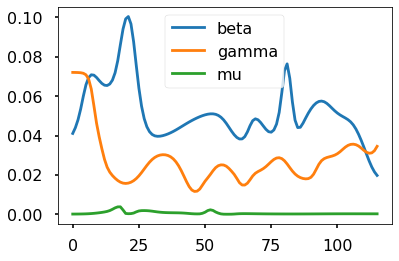

In [106]:
plt.plot(T,beta1)
plt.plot(T,gamma1)
plt.plot(T,mu1)
plt.legend(("beta","gamma","mu"))

Text(0.5, 1.0, 'Reproductin Number')

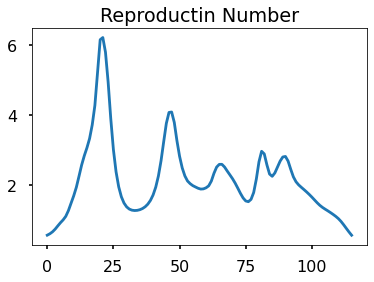

In [107]:
R01 = beta1/(mu1+gamma1)
plt.plot(T,R01)
plt.title("Reproductin Number")